In [1]:
#Technical Analysis Systems (Apostolos Dasilas)
#Taouktsis Xenofon (dai19312)
#Υπολογισμοί Price Oscillator
#Δεδομένα από το [investing.com]
#Τα δεδομένα (.csv) όπως τα κατεβάζουμε απευθείας από το investing.com
#Το αρχείο θα έχει όνομα συμβόλου και μετατροπή από π.χ. ETH.csv σε ETH_md.csv
#UPDATE 111220 - v7

**Εισαγωγή Functions**

In [2]:
#Βήμα 1 | Libraries Input
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

#Global
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Βήμα 2 | Upload Dataset Function
def upload_dataset():
    data_upload = files.upload()
    filename = list(data_upload.keys())[0]
    filename = re.sub(".csv", "", filename)
    return filename

In [4]:
#Βήμα 3 | Simple SMA with Plot Function
def sma_info(dataset, window_value, plot_values):
  tmp_sma = pd.DataFrame()
  tmp_sma['Price'] = dataset['Price'].rolling(window=window_value).mean()
  tmp_sma.columns = ['Price'+'_SMA'+ str(window_value)]
  if plot_values == True:
      plt.plot(tmp_sma)
      plt.plot(dataset['Price'])
      plt.show()
  return tmp_sma

In [5]:
#Βήμα 4 | Price Oscillator calculation Formula
def posc_calculation(dataset,window_value_A,window_value_B,window_value_C):
    plot_values = False
    drop_columns = ['Open', 'High', 'Low', 'Volume']
    dset = dataset.drop(columns = drop_columns)
    SMA_A = sma_info(dataset,window_value_A,plot_values)
    SMA_B = sma_info(dataset,window_value_B,plot_values)
    P_OSC = pd.DataFrame(((SMA_A.iloc[:,0] - SMA_B.iloc[:,0])/SMA_B.iloc[:,0])*100)
    P_OSC.columns = ['Price_Osc']
    SMA_C = pd.DataFrame(P_OSC['Price_Osc'].rolling(window=window_value_C).mean())
    SMA_C.columns = ['Price'+'_SMA'+ str(window_value_C)]
    result_values = pd.DataFrame()
    result_values = pd.concat([dset, SMA_A, SMA_B, P_OSC, SMA_C], axis=1)
    return result_values

In [6]:
#Βήμα 5 | Price OSC - Signal to Buy or to Sell Report Function
def posc_signal_buy_sell_report(data_input):
    ###
    diff_check = []
    range_a = data_input.isna().sum()[5]
    for i in range(range_a):
        diff_check.append(np.nan)
    diff_check = pd.DataFrame(diff_check)
    diff_values = pd.DataFrame(data_input.iloc[range_a:,4] - data_input.iloc[range_a:,5])
    diff_combine = pd.DataFrame()
    diff_combine = pd.concat([diff_check, diff_values], axis=0)
    diff_combine.columns = ['diff']
    data_input = pd.concat([data_input, diff_combine], axis=1)

    check_signal = []
    for i in range(range_a):
        check_signal.append(np.nan)

    c = range_a-1
    range_b = len(data_input)-1
    for i in range(c,range_b):
        if data_input.iloc[:,6][i+1] < 0:
            check_signal.append(-1)
        else:
            check_signal.append(1)

    check_signal = pd.DataFrame(check_signal)
    check_signal.columns = ['flag']
    ###

    ###
    signals = []
    range_c = check_signal.isna().sum()[0]+1
    for i in range(range_c):
        signals.append(np.nan)

    range_value = len(check_signal)
    i=range_c
    while i < (range_value):
        tmp_value = check_signal['flag'][i-1]
        tmp_next_value = check_signal['flag'][i]
        if tmp_next_value == tmp_value:
            signals.append(np.nan)
        else:
            signals.append(tmp_next_value)
        i = i + 1
    signals = pd.DataFrame(signals)
    signals.columns = ["Buy_Sell_Flag"]
    ###

    ###
    drop_columns = [2,3,4,5,6]
    tmp_dataset = data_input.drop(data_input.columns[drop_columns],axis=1)
    signal_prices = pd.DataFrame()
    signal_prices = pd.concat([tmp_dataset,signals], axis=1)
    ###

    ###
    DATA_A = pd.DataFrame(signal_prices.iloc[:,1]) #Price (close values)
    DATA_B = pd.DataFrame(signal_prices.iloc[:,2]) #Flag Buy or Sell (Price OSC)
    length_dataset = len(signal_prices)

    signal_buy = []
    signal_sell = []
    flag_id = 0
    for i in range(length_dataset):
        if DATA_B.iloc[:,0][i] == 1:
            if flag_id != 2:
                signal_buy.append(DATA_A['Price'][i])
                signal_sell.append(np.nan)
                flag_id = 2
            else:
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        elif  DATA_B.iloc[:,0][i] == -1:
            if flag_id !=1:
                signal_buy.append(np.nan)
                signal_sell.append(DATA_A['Price'][i])
                flag_id = 1
            else:
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        else:
            signal_buy.append(np.nan)
            signal_sell.append(np.nan)
    ###

    ###
    report_buy_sell = pd.DataFrame()
    report_buy_sell['Date'] = dataset.iloc[:,0]
    report_buy_sell['signal_buy_price'] = signal_buy
    report_buy_sell['signal_sell_price'] = signal_sell
    ###

    ###
    dates_to_buy = report_buy_sell.loc[report_buy_sell['signal_buy_price']>0]
    dates_to_buy = dates_to_buy.drop(dates_to_buy.columns[2],axis=1)
    dates_to_sell = report_buy_sell.loc[report_buy_sell['signal_sell_price']>0]
    dates_to_sell = dates_to_sell.drop(dates_to_sell.columns[1],axis=1)
    ###

    ###
    dates_buy_sell = pd.concat([dates_to_buy, dates_to_sell])
    dates_buy_sell.sort_index(inplace=True)
    dates_buy_sell.set_index('Date', inplace = True)
    ###
    return (report_buy_sell, dates_buy_sell)

In [7]:
#Βήμα 6 | Plot Total Signal Report (Price OSC)
def posc_plot_total_signals(metric_results,total_dates_report):
    #import datetime
    #plt.style.use('default')
    #plt.style.use('fivethirtyeight')

    symbol_name = re.sub("_md", "", filename)


    fig1, ax1 = plt.subplots(figsize=(13, 5))
    metric_results = metric_results.set_index(pd.DatetimeIndex(metric_results['Date'].values))

    plt.plot(metric_results['Price'], label = symbol_name, alpha = 0.80, color = 'violet')

    total_dates_report = total_dates_report.set_index(pd.DatetimeIndex(metric_results['Date'].values))

    #Check Null Signals
    if len(total_dates_report) != total_dates_report.isnull().sum().sum()/2 :
      plt.scatter(total_dates_report.index, total_dates_report['signal_buy_price'],label = 'Buy',marker = '^', color = 'forestgreen')
      plt.scatter(total_dates_report.index, total_dates_report['signal_sell_price'], label = 'Sell', marker = 'v', color = 'black')

    plt.title('Buy and Sell Signals | Symbol: ' + symbol_name + ' [Price History]')
    plt.ylabel('Price USD')
    plt.legend(loc=2, prop={'size': 7})
    ax1.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.tight_layout()
    plt.show()

    #Price OSC PLOT
    fig2, ax2 = plt.subplots(figsize=(13, 5))
    sma_a_name = metric_results.columns[5]
    sma_a_label = re.sub("Price_", "", sma_a_name)
    posc_name = metric_results.columns[4]
    plt.plot(metric_results[posc_name], label = posc_name, alpha = 0.80, color = 'red')
    plt.plot(metric_results[sma_a_name], label = sma_a_label, alpha = 0.80,  color = 'blue')

    #plt.axhline(0, linestyle='dotted', color = 'red')
    #plt.title(posc_name+' PLOT')
    plt.ylabel(posc_name +' values')
    ax2.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.legend(loc=2, prop={'size': 7})
    plt.tight_layout()
    plt.show()
    return

**Απευθείας CSV to CSV_md - INVESTING.COM**

In [8]:
#Βήμα SOS
#Direct CSV to CSV_md (investing.com)
def md_csv_dataset(filename):
    chart = pd.read_csv(filename+".csv",
                        sep = ',')
    n_col = len(chart.columns)
    chart = chart.drop(chart.columns[n_col-1],axis=1)

    if len(chart.columns) < 6 :
        chart['Volume'] = 0
        id = 1
    else :
        id = 0

    chart.columns = ['Date','Price',
                    'Open','High',
                    'Low','Volume']

    #Μορφή Ημερομηνίας
    chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')

    chart = chart.replace(',','', regex=True)
    chart = chart.replace('%','', regex=True)
    chart.iloc[:,1:6] = chart.iloc[:,1:6].replace('-','0', regex=True)

    chart['Date'] = chart['Date'].astype(np.datetime64)
    chart['Date'] = chart['Date'].dt.date
    chart['Price'] = chart['Price'].astype(np.float64)
    chart['Open'] = chart['Open'].astype(np.float64)
    chart['High'] = chart['High'].astype(np.float64)
    chart['Low'] = chart['Low'].astype(np.float64)

    if id!=1:
        for i in range(len(chart)):
            tmp_value = chart.iloc[i,5]
            if tmp_value != re.sub("K", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("K", "",tmp_value)) * 1000
            elif tmp_value != re.sub("M", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("M", "",tmp_value)) * 1000000
            elif  tmp_value != re.sub("B", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("B", "",tmp_value)) * 1000000000
        chart['Volume'] = chart['Volume'].astype(np.float64)
    else:
        #update 111220
        chart['Volume'] = 0 #Υπήρχε θέμα με το volume οπότε το θέτω με μηδέν ( 0 ) όταν δεν υπάρχει η στήλη από το investing.com
        #md_col = len(chart.columns)
        #chart = chart.drop(chart.columns[md_col-1],axis=1)

    chart.sort_values(by=['Date'], inplace=True, ascending=True)

    #update 081220
    chart.index = range(len(chart['Date']))

    return chart

**Αρχή Διαδικασιών Price Oscillator**

In [13]:
#Βήμα 1 | Upload .csv Dataset (.csv)
filename = upload_dataset()
filename
#Το αποτέλεσμα θα είναι π.χ. filename = "AAPL"

Saving INTC Ιστορικά Δεδομένα(2).csv to INTC Ιστορικά Δεδομένα(2) (1).csv


'INTC Ιστορικά Δεδομένα(2) (1)'

In [14]:
#Βήμα 2 | Creation of Dataset (load .csv file)
#Επιλογές Υποδιαστολής
#American xlsx επιλογή decimal_select = '.' εάν το csv έχει αποθηκευτεί με ( . )
#European xlsx επιλογή decimal_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#Επιλογή Διαχωρισμού Στηλών
#European xlsx sep_select = ';' εάν το csv έχει αποθηκευτεί με ( ; )
#American xlsx sep_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#decimal_select = ',' #Υποδιαστολή
#sep_select = ';' #Διαχωρισμός Στηλών

dataset = md_csv_dataset(filename)
dataset

<ipython-input-8-052c46b199ca>:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')


Date   Price    Open    High     Low        Volume
0    2022-01-11  2830.0  2880.0  2885.0  2789.0  4.442000e+09
1    2022-01-12  2983.0  3024.0  3048.0  2952.0  3.890000e+09
2    2022-02-11  2742.0  2827.0  2885.0  2741.0  5.196000e+09
3    2022-02-12  2941.0  2917.0  2943.0  2871.0  3.155000e+09
4    2022-03-11  2739.0  2745.0  2788.0  2717.0  3.968000e+09
..          ...     ...     ...     ...     ...           ...
248  2023-12-05  2895.0  2902.0  2910.0  2872.0  2.415000e+09
249  2023-12-06  3307.0  3140.0  3330.0  3136.0  5.967000e+09
250  2023-12-07  3398.0  3369.0  3408.0  3306.0  3.728000e+09
251  2023-12-09  3886.0  3865.0  4007.0  3865.0  5.465000e+09
252  2023-12-10  3684.0  3680.0  3722.0  3639.0  2.356000e+09

[253 rows x 6 columns]

In [15]:
#Βήμα 3 | Price OSC Results Analysis
window_value_A = 5
window_value_B = 60
window_value_C = 45 #Line CrossOver Line
posc_results = posc_calculation(dataset,window_value_A,window_value_B,window_value_C)
posc_results

Date   Price  Price_SMA5  Price_SMA60  Price_Osc  Price_SMA45
0    2022-01-11  2830.0         NaN          NaN        NaN          NaN
1    2022-01-12  2983.0         NaN          NaN        NaN          NaN
2    2022-02-11  2742.0         NaN          NaN        NaN          NaN
3    2022-02-12  2941.0         NaN          NaN        NaN          NaN
4    2022-03-11  2739.0      2847.0          NaN        NaN          NaN
..          ...     ...         ...          ...        ...          ...
248  2023-12-05  2895.0      3334.6  3360.200000  -0.761859     0.544961
249  2023-12-06  3307.0      3224.2  3362.283333  -4.106832     0.422874
250  2023-12-07  3398.0      3166.2  3360.550000  -5.783280     0.233636
251  2023-12-09  3886.0      3337.6  3361.966667  -0.724774     0.210105
252  2023-12-10  3684.0      3434.0  3363.900000   2.083891     0.326635

[253 rows x 6 columns]

In [16]:
#Βήμα 4 | Price OSC First 60 results
posc_results.head(n=60)

Date   Price  Price_SMA5  Price_SMA60  Price_Osc  Price_SMA45
0   2022-01-11  2830.0         NaN          NaN        NaN          NaN
1   2022-01-12  2983.0         NaN          NaN        NaN          NaN
2   2022-02-11  2742.0         NaN          NaN        NaN          NaN
3   2022-02-12  2941.0         NaN          NaN        NaN          NaN
4   2022-03-11  2739.0      2847.0          NaN        NaN          NaN
5   2022-04-11  2820.0      2845.0          NaN        NaN          NaN
6   2022-05-12  2917.0      2831.8          NaN        NaN          NaN
7   2022-06-12  2860.0      2855.4          NaN        NaN          NaN
8   2022-07-11  2841.0      2835.4          NaN        NaN          NaN
9   2022-07-12  2833.0      2854.2          NaN        NaN          NaN
10  2022-08-11  2848.0      2859.8          NaN        NaN          NaN
11  2022-08-12  2844.0      2845.2          NaN        NaN          NaN
12  2022-09-11  2752.0      2823.6          NaN        NaN          NaN
13  2022-09-12  2824.0      2820.2          NaN        NaN          NaN
14  2022-10-11  2976.0      2848.8          NaN        NaN          NaN
15  2022-10-18  2587.0      2796.6          NaN        NaN          NaN
16  2022-10-19  2600.0      2747.8          NaN        NaN          NaN
17  2022-10-20  2608.0      2719.0          NaN        NaN          NaN
18  2022-10-21  2697.0      2693.6          NaN        NaN          NaN
19  2022-10-24  2718.0      2642.0          NaN        NaN          NaN
20  2022-10-25  2741.0      2672.8          NaN        NaN          NaN
21  2022-10-26  2721.0      2697.0          NaN        NaN          NaN
22  2022-10-27  2627.0      2700.8          NaN        NaN          NaN
23  2022-10-28  2907.0      2742.8          NaN        NaN          NaN
24  2022-10-31  2843.0      2767.8          NaN        NaN          NaN
25  2022-11-11  3043.0      2828.2          NaN        NaN          NaN
26  2022-11-14  3035.0      2891.0          NaN        NaN          NaN
27  2022-11-15  3071.0      2979.8          NaN        NaN          NaN
28  2022-11-16  2953.0      2989.0          NaN        NaN          NaN
29  2022-11-17  2989.0      3018.2          NaN        NaN          NaN
30  2022-11-18  2987.0      3007.0          NaN        NaN          NaN
31  2022-11-21  2894.0      2978.8          NaN        NaN          NaN
32  2022-11-22  2982.0      2961.0          NaN        NaN          NaN
33  2022-11-23  2967.0      2963.8          NaN        NaN          NaN
34  2022-11-25  2934.0      2952.8          NaN        NaN          NaN
35  2022-11-28  2873.0      2930.0          NaN        NaN          NaN
36  2022-11-29  2890.0      2929.2          NaN        NaN          NaN
37  2022-11-30  3007.0      2934.2          NaN        NaN          NaN
38  2022-12-12  2869.0      2914.6          NaN        NaN          NaN
39  2022-12-13  2873.0      2902.4          NaN        NaN          NaN
40  2022-12-14  2826.0      2893.0          NaN        NaN          NaN
41  2022-12-15  2715.0      2858.0          NaN        NaN          NaN
42  2022-12-16  2692.0      2795.0          NaN        NaN          NaN
43  2022-12-19  2679.0      2757.0          NaN        NaN          NaN
44  2022-12-20  2644.0      2711.2          NaN        NaN          NaN
45  2022-12-21  2683.0      2682.6          NaN        NaN          NaN
46  2022-12-22  2597.0      2659.0          NaN        NaN          NaN
47  2022-12-23  2609.0      2642.4          NaN        NaN          NaN
48  2022-12-27  2594.0      2625.4          NaN        NaN          NaN
49  2022-12-28  2554.0      2607.4          NaN        NaN          NaN
50  2022-12-29  2621.0      2595.0          NaN        NaN          NaN
51  2022-12-30  2643.0      2604.2          NaN        NaN          NaN
52  2023-01-02  2907.0      2663.8          NaN        NaN          NaN
53  2023-01-03  2533.0      2651.6          NaN        NaN          NaN
54  2023-01-05  3030.0      2746.8          NaN   

In [17]:
#Βήμα 5 | Price OSC Last 60 results
posc_results.tail(n=60)

Date   Price  Price_SMA5  Price_SMA60  Price_Osc  Price_SMA45
193  2023-08-15  3477.0      3506.0  3245.800000   8.016514     4.933863
194  2023-08-16  3353.0      3540.2  3252.016667   8.861681     5.211335
195  2023-08-17  3258.0      3491.4  3257.616667   7.176515     5.456078
196  2023-08-18  3275.0      3386.2  3264.083333   3.741224     5.579007
197  2023-08-21  3314.0      3335.4  3269.850000   2.004679     5.547269
198  2023-08-22  3289.0      3297.8  3274.783333   0.702845     5.340633
199  2023-08-23  3398.0      3306.8  3280.950000   0.787882     5.117589
200  2023-08-24  3259.0      3307.0  3286.083333   0.636523     4.836059
201  2023-08-25  3325.0      3317.0  3293.166667   0.723721     4.511777
202  2023-08-28  3362.0      3326.6  3303.533333   0.698242     4.206586
203  2023-08-29  3431.0      3355.0  3312.383333   1.286586     3.937992
204  2023-08-30  3453.0      3366.0  3319.950000   1.387069     3.690166
205  2023-08-31  3514.0      3417.0  3326.116667   2.732416     3.517748
206  2023-09-01  2931.0      3338.2  3327.083333   0.334126     3.337934
207  2023-09-02  2773.0      3220.4  3325.483333  -3.159942     3.129959
208  2023-09-03  2644.0      3063.0  3326.233333  -7.913857     2.835356
209  2023-09-05  3010.0      2974.4  3321.716667 -10.455939     2.480036
210  2023-09-06  3134.0      2898.4  3322.350000 -12.760546     2.075300
211  2023-09-08  3428.0      2997.8  3326.200000  -9.873128     1.733674
212  2023-09-10  3606.0      3164.4  3324.666667  -4.820533     1.561456
213  2023-09-13  3871.0      3409.8  3328.866667   2.431258     1.663093
214  2023-09-14  3867.0      3581.2  3336.800000   7.324383     1.904125
215  2023-09-15  3788.0      3712.0  3340.633333  11.116655     2.249040
216  2023-09-18  3799.0      3786.2  3344.250000  13.215220     2.617843
217  2023-09-19  3634.0      3791.8  3344.200000  13.384367     2.870513
218  2023-09-20  3469.0      3711.4  3343.683333  10.997353     2.951891
219  2023-09-21  3465.0      3631.0  3346.600000   8.498177     2.948035
220  2023-09-22  3418.0      3557.0  3349.050000   6.209224     2.860870
221  2023-09-25  3429.0      3483.0  3351.200000   3.932920     2.736677
222  2023-09-26  3383.0      3432.8  3352.016667   2.409992     2.633547
223  2023-09-27  3461.0      3431.2  3352.866667   2.336309     2.537674
224  2023-09-28  3518.0      3441.8  3355.550000   2.570368     2.438434
225  2023-09-29  3555.0      3469.2  3359.950000   3.251536     2.368064
226  2023-10-01  2944.0      3372.2  3353.283333   0.564124     2.248207
227  2023-10-02  2780.0      3251.6  3351.200000  -2.972070     2.056901
228  2023-10-03  2722.0      3103.8  3354.016667  -7.460209     1.756455
229  2023-10-04  3252.0      3050.6  3356.083333  -9.102376     1.390324
230  2023-10-05  2997.0      2939.0  3352.950000 -12.345845     0.930021
231  2023-10-07  3274.0      3005.0  3348.800000 -10.266364     0.592907
232  2023-10-08  3468.0      3142.6  3342.966667  -5.993678     0.464021
233  2023-10-10  3643.0      3326.8  3347.233333  -0.610454     0.504413
234  2023-10-13  3597.0      3395.8  3351.933333   1.308697     0.657284
235  2023-10-16  3656.0      3527.6  3355.583333   5.126282     0.910847
236  2023-10-17  3606.0      3594.0  3358.183333   7.022150     1.078783
237  2023-10-18  3564.0      3613.2  3360.150000   7.530914     1.124111
238  2023-10-19  3567.0      3598.0  3363.983333   6.956535     1.100556
239  2023-11-01  2985.0      3475.6  3357.033333   3.531888     0.982116
240  2023-11-04  3235.0      3391.4  3354.900000   1.087961     0.846815
241  2023-11-05  2886.0      3247.4  3346.166667  -2.951636     0.698085
242  2023-11-07  3330.0      3200.6  3344.400000  -4.299725     0.557987
243  2023-11-08  3489.0      3185.0  3344.966667  -4.782310     0.436095
244  2023-11-09  3859.0      3359.8  3347.900000   0.355447     0.426485
245  2023-11-10  3688.0      3450.4  3349.750000   3.004702     0.479111
246  2023-12-01  3029.0      3479.0  3353.166667   3.752672     0.546

In [18]:
#Βήμα 6 | Total Date Signals (Buy or Sell) Price OSC Report
data_input = posc_results
posc_total_dates_report, posc_signals_buy_sell = posc_signal_buy_sell_report(data_input)
posc_signals_buy_sell

signal_buy_price  signal_sell_price
Date                                           
2023-03-29            3152.0                NaN
2023-04-25               NaN             2888.0
2023-05-09            3671.0                NaN
2023-05-18               NaN             2968.0
2023-06-09            3698.0                NaN
2023-07-02               NaN             2905.0
2023-07-13            3387.0                NaN
2023-08-03               NaN             2598.0
2023-08-14            3568.0                NaN
2023-08-18               NaN             3275.0
2023-09-13            3871.0                NaN
2023-09-26               NaN             3383.0
2023-09-28            3518.0                NaN
2023-10-01               NaN             2944.0
2023-10-13            3597.0                NaN
2023-11-05               NaN             2886.0
2023-11-10            3688.0                NaN
2023-12-05               NaN             2895.0
2023-12-10            3684.0                NaN

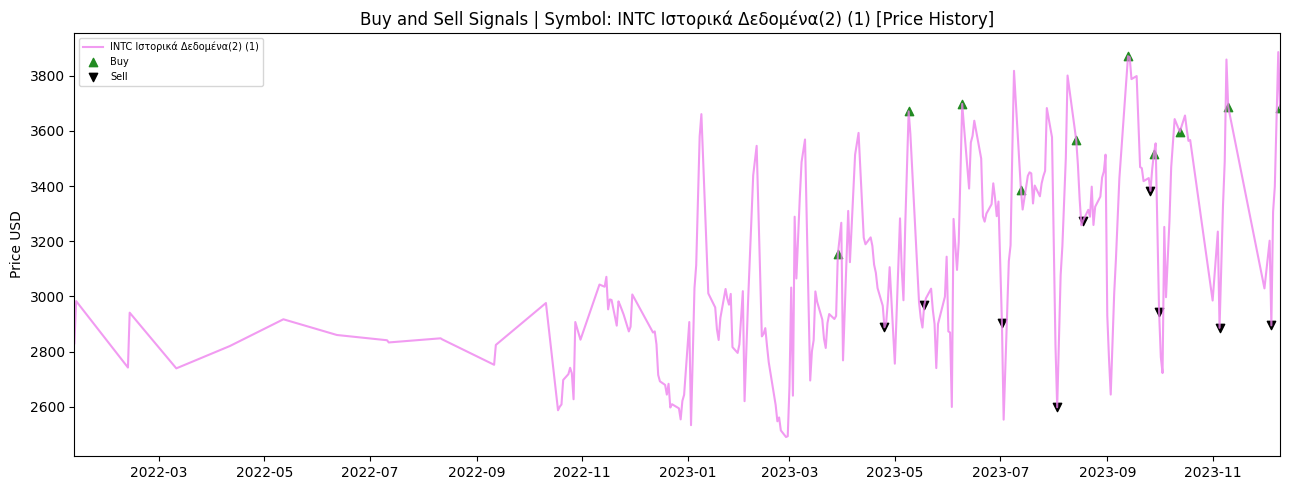

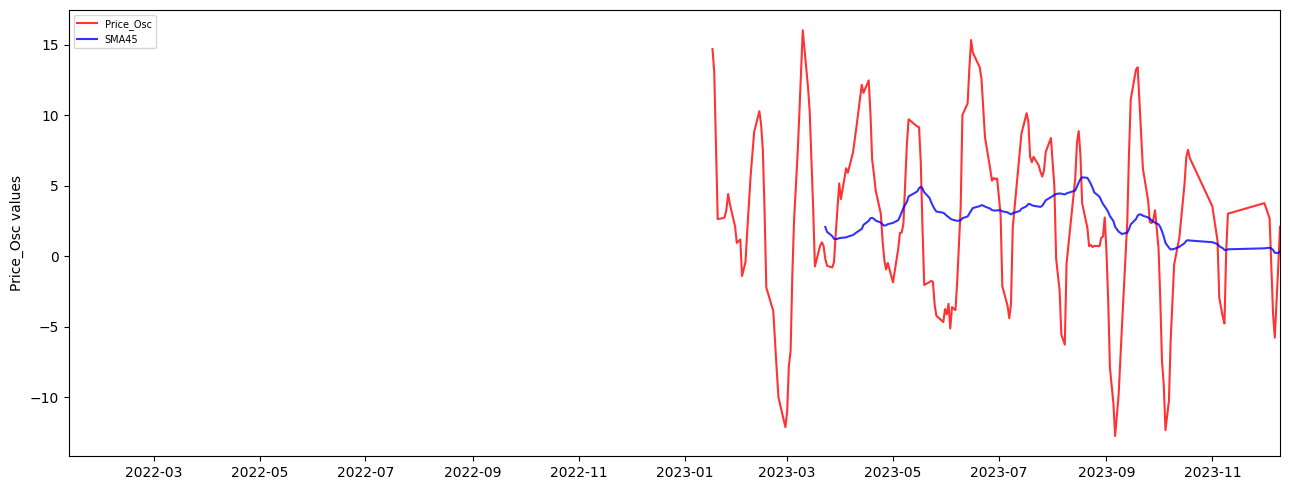

In [19]:
#Βήμα 7 | PMO Plot Analysis (Buy and Sell Signals)
posc_plot_total_signals(posc_results,posc_total_dates_report)